# <center>Логнормальное распределение целевой переменной</center>

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

## 1. Предварительный анализ данных

Рассмотрим данные о стоимости недвижимости в США в 2014-2015 гг.

В качестве целевой переменной выступает стоимость недвижимости. Для каждого объекта недвижимости известны такие дополнительные характеристики как:
- количество спален;
- площадь жилого помещения.

In [2]:
house_sales = pd.read_csv('data/house_sales.csv')

In [3]:
house_sales.head()

,price,bedrooms,sqft_living
0,221900.0,3,1180
1,538000.0,3,2570
2,180000.0,2,770
3,604000.0,4,1960
4,510000.0,3,1680


Поставленную задачу будем решать с помощью модели линейной регрессии. Проведем визуальный анализ данных.

Для предварительной оценки целевой переменной и выбора базовой модели достаточно построить гистограмму распределения.

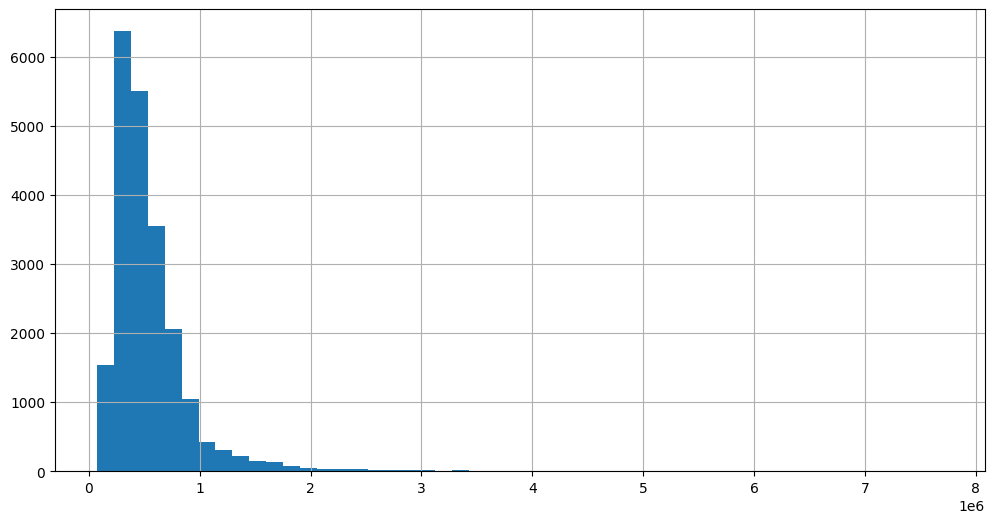

In [4]:
house_sales['price'].hist(figsize=(12,6), bins=50)
plt.show()

Как видно на гистограмме, целевая переменная имеет длинный правый хвост, что характерно для логнормального распределения. Прологарифмируем целевую переменную и построим гистограмму новой целевой переменной $\ln y$.

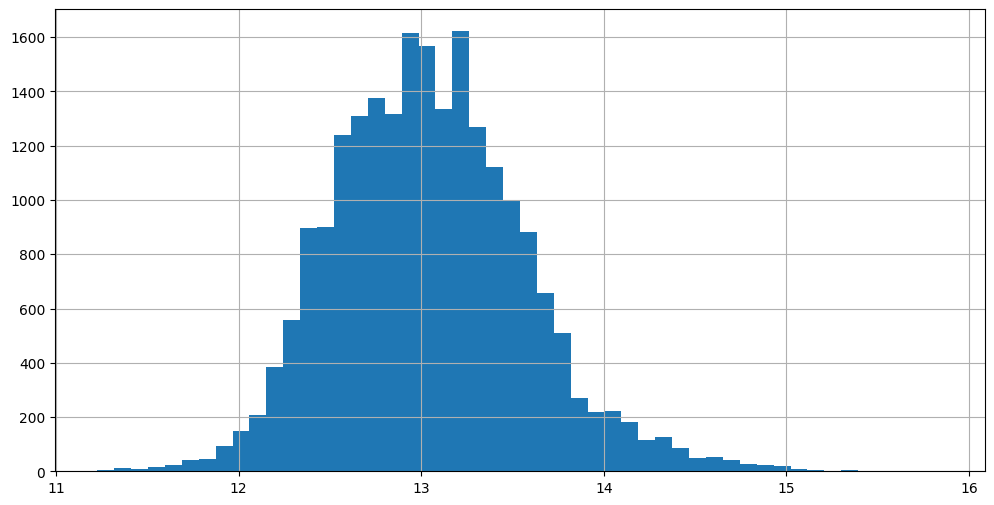

In [5]:
plt.figure(figsize=(12,6))
np.log(house_sales['price']).hist(figsize=(12,6), bins=50)
plt.show()

## 2. Построение модели линейной регрессии

Воспользуемся пакетом sklearn для построения предсказательной модели. Качество построенной модели будем оценивать с помощью кросс-валидации.

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.compose import TransformedTargetRegressor

In [7]:
model = LinearRegression()

Для сравнения качества моделей для исходной целевой переменной и логарифмированной оценка должна проводиться при одинаковом масштабе данных. Т.е. для второго случая необходимо сначала прологарифмировать целевую переменную, построить модель, а затем результаты предсказаний потенцировать. Такую последовательность действий в `cross_val_score` можно передать через `sklearn.compose.TransformedTargetRegressor`.

In [8]:
def func(y):
    return np.log(y)

def inverse_func(y):
    return np.exp(y)

In [9]:
model_log = TransformedTargetRegressor(regressor=model, 
                                       func=func, 
                                       inverse_func=inverse_func)

Запишем в `X` матрицу объекты-признаки, а в `y` &ndash; целевую переменную соответственно и оценим качество обеих моделей на кросс-валидации.

In [10]:
X = house_sales.drop('price', axis=1)
y = house_sales['price']

In [11]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)

In [12]:
cv_scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_absolute_error')
cv_scores_log = cross_val_score(model_log, X, y, cv=kf, scoring='neg_mean_absolute_error')

In [13]:
print('Оценка MAE модели для исходной целевой переменной:  %.4f' % cv_scores.mean())
print('Оценка MAE модели для логарифма целевой переменной: %.4f' % cv_scores_log.mean())

Оценка MAE модели для исходной целевой переменной:  -170360.2134
Оценка MAE модели для логарифма целевой переменной: -167276.7086


Посмотрим теперь на распределения признаков:

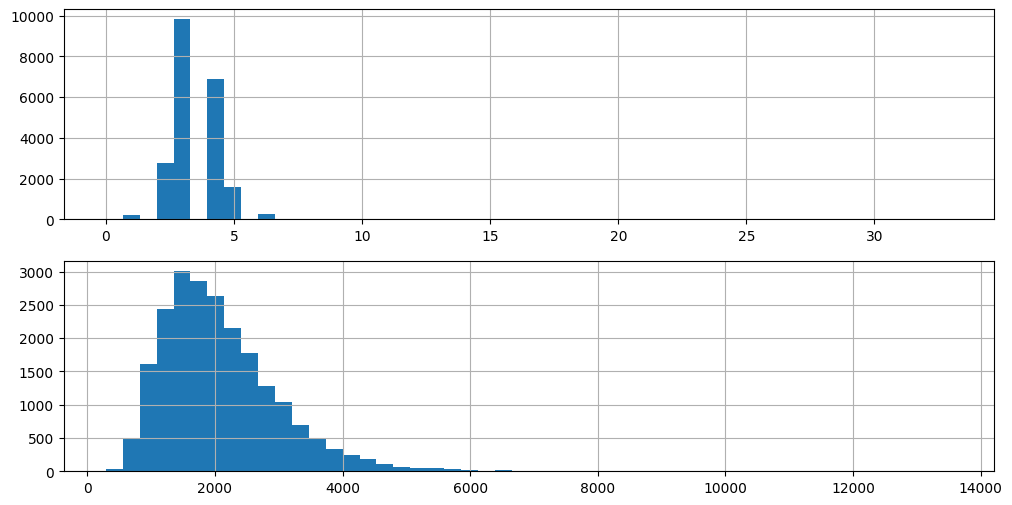

In [14]:
fig, axarr = plt.subplots(2, 1, figsize=(12,6))

house_sales['bedrooms'].hist(figsize=(12,6), bins=50, ax=axarr[0])
house_sales['sqft_living'].hist(figsize=(12,6), bins=50, ax=axarr[1])

plt.show()

Как видно, признаки, по которым строилась модель также имеют длинный правый хвост. Соответственно, чтобы сохранить зависимость между целевой переменной и признаками их также необходимо прологарифмировать.

In [15]:
X_log = np.log1p(house_sales[['bedrooms', 'sqft_living']])

In [16]:
cv_scores = cross_val_score(model, X_log, y, cv=kf, scoring='neg_mean_absolute_error')
cv_scores_log = cross_val_score(model_log, X_log, y, cv=kf, scoring='neg_mean_absolute_error')

In [17]:
print('Оценка MAE модели для исходной целевой переменной:  %.4f' % cv_scores.mean())
print('Оценка MAE модели для логарифма целевой переменной: %.4f' % cv_scores_log.mean())

Оценка MAE модели для исходной целевой переменной:  -184944.6781
Оценка MAE модели для логарифма целевой переменной: -166128.0939


Значение метрики качества предсказаний оказалось лучше качества, полученного ранее.